# 19장 샘플링과 신뢰도

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/python4daml/blob/main/19장.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
import matplotlib.pyplot as plt

#선 두께
plt.rcParams['lines.linewidth'] = 4
#제목 폰트 크기
plt.rcParams['axes.titlesize'] = 20
#축 레이블 폰트 크기
plt.rcParams['axes.labelsize'] = 20
#x 축 텍스트 크기
plt.rcParams['xtick.labelsize'] = 16
#y 축 텍스트 크기
plt.rcParams['ytick.labelsize'] = 16
#x 축 눈금 크기
plt.rcParams['xtick.major.size'] = 7
#y 축 눈금 크기
plt.rcParams['ytick.major.size'] = 7
#마커 크기
plt.rcParams['lines.markersize'] = 10
#범례를 표시할 때 마커 표시 개수
plt.rcParams['legend.numpoints'] = 1
#범례 텍스트 크기
plt.rcParams['legend.fontsize'] = 14

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

## 보스턴 마라톤 데이터 샘플링

In [3]:
# 코랩에서 실행하는 경우 다음 명령의 주석을 해제하고 실행하세요.
#!wget https://raw.githubusercontent.com/rickiepark/python4daml/main/bm_results2012.csv

그림 19-2 보스턴 마라톤 데이터를 읽고 그래프 그리기

In [4]:
def get_BM_data(filename):
    """주어진 파일의 내용을 읽습니다.
       파일은 CSV 포맷이고 다음과 같은 6개의 항목으로 이루어졌다고 가정합니다.
       0. 이름 (문자열), 1. 성별 (문자열), 2 나이 (정수)
       3. 부문 (정수), 4. 국적 (문자열), 5. 시간 (실수)
       반환값: 6개 항목에 대한 리스트를 담은 딕셔너리"""

    data = {}
    with open(filename, 'r') as f:
        f.readline() #첫 번째 줄은 버립니다
        line = f.readline()
        for k in ('name', 'gender', 'age', 'division',
                  'country', 'time'):
            data[k] = []
        while line != '':
            split = line.split(',')
            data['name'].append(split[0])
            data['gender'].append(split[1])
            data['age'].append(int(split[2]))
            data['division'].append(int(split[3]))
            data['country'].append(split[4])
            data['time'].append(float(split[5][:-1])) #remove \n
            line = f.readline()
    return data

def make_hist(data, bins, title, xLabel, yLabel):
    plt.hist(data, bins)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    mean = sum(data)/len(data)
    std = np.std(data)
    plt.annotate('Mean = ' + str(round(mean, 2)) +
                 '\nSD = ' + str(round(std, 2)), fontsize = 14,
                 xy = (0.65, 0.75), xycoords = 'axes fraction')

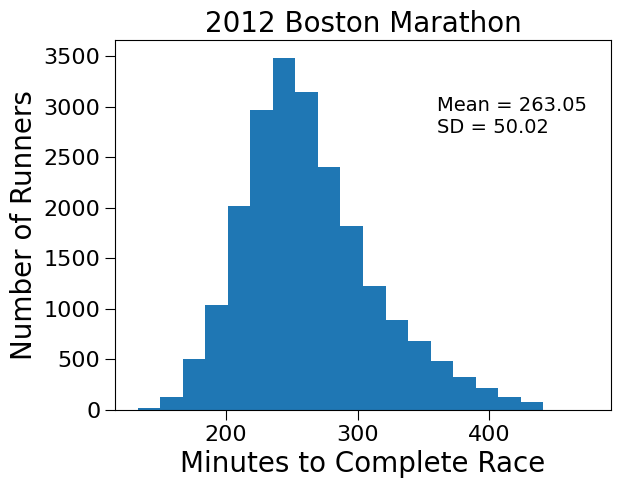

In [5]:
times = get_BM_data('bm_results2012.csv')['time']
make_hist(times, 20, '2012 Boston Marathon',
          'Minutes to Complete Race', 'Number of Runners')

그림 19-4 완주 시간 샘플링

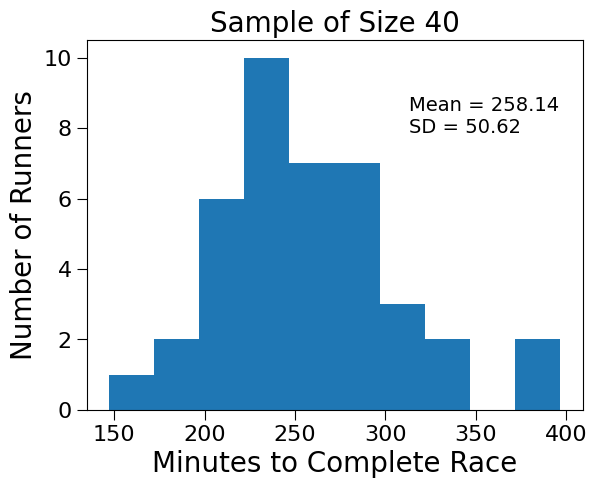

In [6]:
def sample_times(times, num_examples):
    """times는 전체 선수의 완주 시간을 담은 실수 리스트이고,
       num_examples는 정수라고 가정합니다.
       num_examples 크기의 랜덤 샘플을 생성하고 
       샘플의 평균과 표준 편차와 함께 분포를 나타내는 히스토그램을 그립니다"""

    sample = random.sample(times, num_examples)
    make_hist(sample, 10, 'Sample of Size ' + str(num_examples),
              'Minutes to Complete Race', 'Number of Runners')

sample_size = 40
sample_times(times, sample_size)

그림 19-6 평균 추정에 대한 분산의 효과

In [7]:
def gaussian(x, mu, sigma):
    factor1 = (1/(sigma*((2*np.pi)**0.5)))
    factor2 = np.e**-(((x-mu)**2)/(2*sigma**2))
    return factor1*factor2

area = round(scipy.integrate.quad(gaussian, -3, 3, (0, 1))[0], 4)
print('좁은 분포일 때 평균에서 3 이내에 있을 확률 =', area)
area = round(scipy.integrate.quad(gaussian, -3, 3, (0, 100))[0], 4)
print('넓은 분포일 때 평균에서 3 이내에 있을 확률 =', area)

좁은 분포일 때 평균에서 3 이내에 있을 확률 = 0.9973
넓은 분포일 때 평균에서 3 이내에 있을 확률 = 0.0239


그림 19-7 샘플 평균 계산하고 그래프 그리기

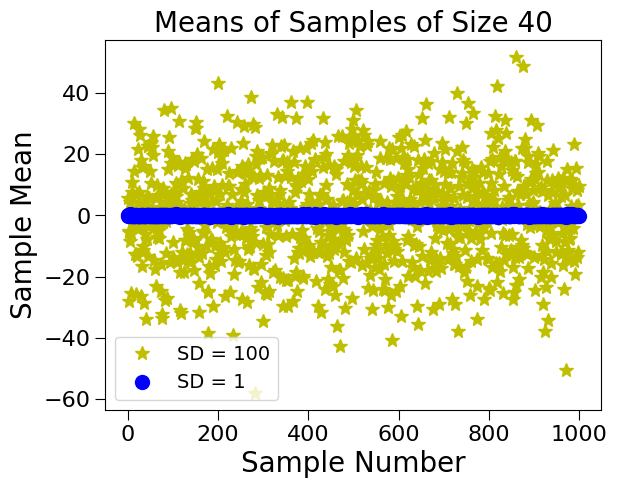

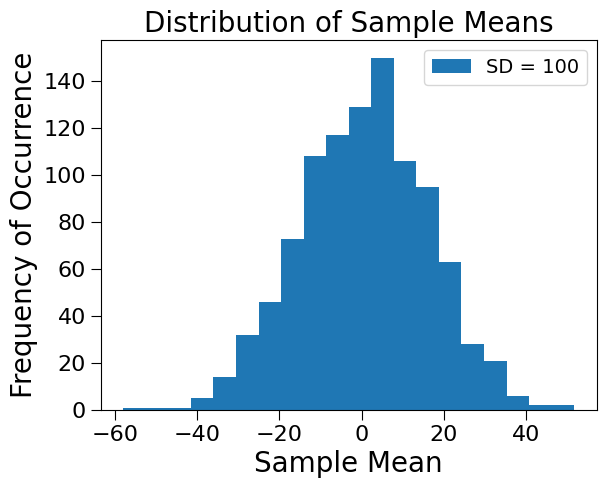

In [8]:
def test_samples(num_trials, sample_size):
    tight_means, wide_means = [], []
    for t in range(num_trials):
        sample_tight, sample_wide = [], []
        for i in range(sample_size):
            sample_tight.append(random.gauss(0, 1))
            sample_wide.append(random.gauss(0, 100))
        tight_means.append(sum(sample_tight)/len(sample_tight))
        wide_means.append(sum(sample_wide)/len(sample_wide))
    return tight_means, wide_means

tight_means, wide_means = test_samples(1000, 40)
plt.plot(wide_means, 'y*', label = 'SD = 100')
plt.plot(tight_means, 'bo', label = 'SD = 1')
plt.xlabel('Sample Number')
plt.ylabel('Sample Mean')
plt.title('Means of Samples of Size ' + str(40))
plt.legend()

plt.figure()
plt.hist(wide_means, bins = 20, label = 'SD = 100')
plt.title('Distribution of Sample Means')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency of Occurrence')
plt.legend()

## 중심 극한 정리

In [9]:
def variance(X): 
    """X는 숫자의 리스트라고 가정합니다. 
       X의 분산을 반환합니다""" 
    mean = sum(X)/len(X) 
    tot = 0.0 
    for x in X: 
        tot += (x - mean)**2 
    return tot/len(X) 

그림 19-9 실숫값이 나오는 주사위의 평균 추정하기

1개의 주사위를 굴렸을 때 평균 = 2.5002 분산 = 2.0838
100개의 주사위를 굴렸을 때 평균 = 2.4997 분산 = 0.0208


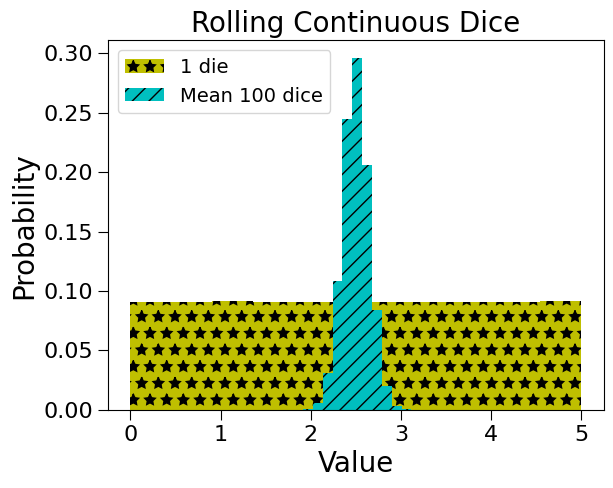

In [10]:
def plot_means(num_dice_per_trial, num_dice_thrown, num_bins,
               legend, color, style):
    means = []
    num_trials = num_dice_thrown//num_dice_per_trial
    for i in range(num_trials):
        vals = 0
        for j in range(num_dice_per_trial):
            vals += 5*random.random()
        means.append(vals/num_dice_per_trial)
    plt.hist(means, num_bins, color = color, label = legend,
             weights = np.array(len(means)*[1])/len(means),
             hatch = style)
    return sum(means)/len(means), np.var(means)

mean, var = plot_means(1, 1000000, 11, '1 die', 'y', '*')
print('1개의 주사위를 굴렸을 때 평균 =', round(mean,4),
      '분산 =', round(var,4))
mean, var = plot_means(100, 1000000, 11,
                       'Mean 100 dice', 'c', '//')
print('100개의 주사위를 굴렸을 때 평균 =', round(mean, 4),
      '분산 =', round(var, 4))
plt.title('Rolling Continuous Dice')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend(loc = 'upper left')

그림 19-11 오차 막대 그래프 그리기

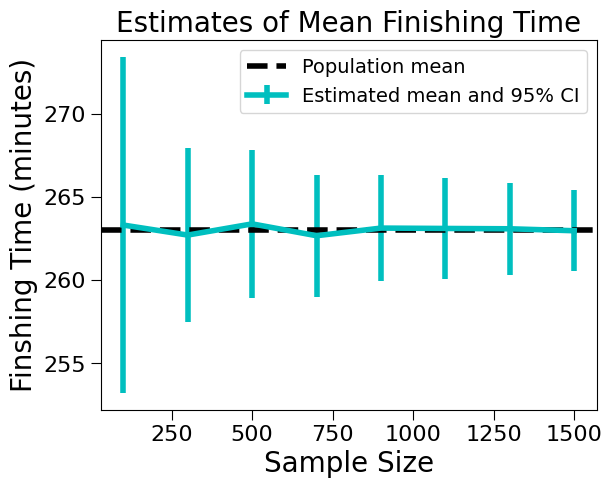

In [11]:
times = get_BM_data('bm_results2012.csv')['time']
mean_of_means, std_of_means = [], []
sample_sizes = range(100, 1501, 200)
for sample_size in sample_sizes:
    sample_means = []
    for t in range(200):
        sample = random.sample(times, sample_size)
        sample_means.append(sum(sample)/sample_size)
    mean_of_means.append(sum(sample_means)/len(sample_means))
    std_of_means.append(np.std(sample_means))
plt.errorbar(sample_sizes, mean_of_means, color = 'c',
             yerr = 1.96*np.array(std_of_means),
             label = 'Estimated mean and 95% CI')
plt.axhline(sum(times)/len(times), linestyle = '--', color = 'k',
            label = 'Population mean')
plt.title('Estimates of Mean Finishing Time')
plt.xlabel('Sample Size')
plt.ylabel('Finshing Time (minutes)')
plt.legend(loc = 'best')

## 19.3 평균의 표준 오차

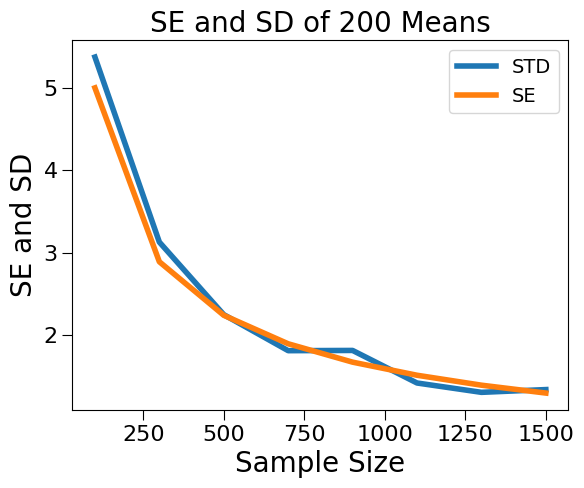

In [12]:
std_of_means, std_errors = [], []
std_of_pop = np.std(times)
for sample_size in sample_sizes:
    sample_means = []
    for t in range(200):
        sample = random.sample(times, sample_size)
        sample_means.append(sum(sample)/sample_size)
    std_of_means.append(np.std(sample_means))
    std_errors.append(std_of_pop/np.sqrt(sample_size))
plt.plot(sample_sizes, std_of_means, label = 'STD')
plt.plot(sample_sizes, std_errors, label = 'SE')
plt.title('SE and SD of 200 Means')
plt.xlabel('Sample Size')
plt.ylabel('SE and SD')
plt.legend(loc = 'best')
plt.show()

그림 19-14 샘플 표준 편차 vs. 모집단 표준 편차

Text(0.5, 1.0, 'Error in Sample SD vs. Sample Size')

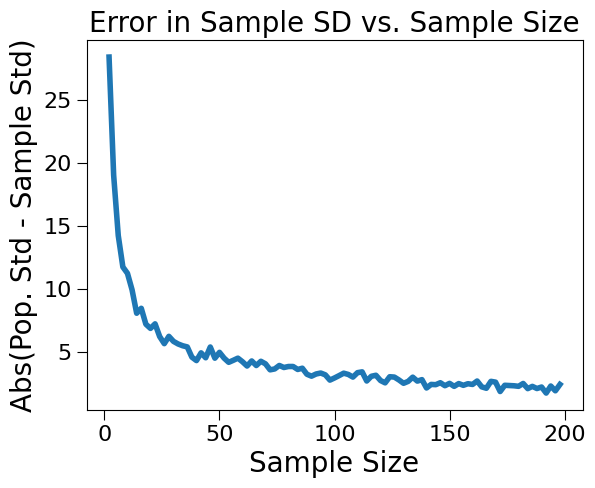

In [13]:
times = get_BM_data('bm_results2012.csv')['time']
pos_std = np.std(times)
sample_sizes = range(2, 200, 2)
diffs_means = []
for sample_size in sample_sizes:
    diffs = []
    for t in range(100):
        diffs.append(abs(pos_std - np.std(random.sample(times,
                                                       sample_size))))
    diffs_means.append(sum(diffs)/len(diffs))
plt.plot(sample_sizes, diffs_means)
plt.xlabel('Sample Size')
plt.ylabel('Abs(Pop. Std - Sample Std)')
plt.title('Error in Sample SD vs. Sample Size')

코드 19-16 10,000번 모집단 평균 추정하기

In [14]:
times = get_BM_data('bm_results2012.csv')['time']
pop_mean = sum(times)/len(times)
sample_size = 200
num_bad = 0
for t in range(10000):
    sample = random.sample(times, sample_size)
    sample_mean = sum(sample)/sample_size
    se = np.std(sample)/sample_size**0.5
    if abs(pop_mean - sample_mean) > 1.96*se:
        num_bad += 1
print('95% 신뢰 구간을 벗어난 비율 =', num_bad/10000)

95% 신뢰 구간을 벗어난 비율 = 0.0542
